<a href="https://colab.research.google.com/github/tomazcavalcantee/IDOR/blob/main/Atividade1_Alunos1_IMPATECH_Alunos_Pipeline_Construcao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 1 (IMPA Tech) — Avaliação do Andar com Vicon (.mat)

**Objetivo:** construir um pipeline simples de ciência de dados aplicado à marcha usando dados do Vicon:

1. **Visualizar dado bruto (RAW)**
2. **Interpolar NaNs**
3. **Suavizar sinal**
4. **Derivar para obter velocidade vertical**
5. **Detectar eventos (proxy)**
6. **Calcular métricas temporais e espaciais (proxy)**

**Participantes (Drive):**
- Participante1_EO_N.mat → **Controle**
- Participante2_EO_N.mat → **PD_ON**
- Participante3_EO_N.mat → **PD_OFF**
- Participante4_EO_N.mat → **Ataxia**

> **Nota científica:** eventos e métricas aqui são **proxies** (cinemáticos). Em pesquisa, eventos podem ser refinados com toe marker, plataformas de força, etc.


In [ ]:
label_legend = {
    "LASI": "Espinha ilíaca ântero-superior esquerda",
    "RASI": "Espinha ilíaca ântero-superior direita",
    "LPSI": "Espinha ilíaca póstero-superior esquerda",
    "RPSI": "Espinha ilíaca póstero-superior direita",

    "LTHI": "Coxa esquerda",
    "RTHI": "Coxa direita",
    "LKNE": "Joelho esquerdo",
    "RKNE": "Joelho direito",

    "LTIB": "Perna esquerda (tíbia)",
    "RTIB": "Perna direita",

    "LANK": "Tornozelo esquerdo",
    "RANK": "Tornozelo direito",

    "LHEE": "Calcanhar esquerdo",
    "RHEE": "Calcanhar direito",
    "LTOE": "Ponta do pé esquerdo",
    "RTOE": "Ponta do pé direito",

    "LFOO": "Pé esquerdo (marcador adicional)",
    "RFOO": "Pé direito (marcador adicional)",

    "CLAV": "Clavícula",
    "C7": "Sétima vértebra cervical",
    "T10": "Décima vértebra torácica",
    "STRN": "Esterno",
    "SACR": "Sacro"
}


## 0) Montar o Google Drive e importar bibliotecas

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# (vamos usar SciPy mais adiante)


Mounted at /content/drive


## 1) Definir pasta e checar arquivos

**Tarefa:** ajuste `base_dir` se necessário e verifique se os arquivos aparecem.

In [ ]:
base_dir = "/content/drive/MyDrive/Colab Notebooks"  # <- ajuste se necessário

print("Arquivos .mat encontrados em:", base_dir)
for f in sorted(os.listdir(base_dir)):
    if f.lower().endswith(".mat"):
        print(" -", f)


Arquivos .mat encontrados em: /content/drive/MyDrive/Colab Notebooks
 - Participante1_EO_N.mat
 - Participante2_EO_N.mat
 - Participante3_EO_N.mat
 - Participante4_EO_N.mat


## 2) Mapear participantes → condição

In [ ]:
files = {
    "Controle": f"{base_dir}/Participante1_EO_N.mat",
    "PD_ON":    f"{base_dir}/Participante2_EO_N.mat",
    "PD_OFF":   f"{base_dir}/Participante3_EO_N.mat",
    "Ataxia":   f"{base_dir}/Participante4_EO_N.mat",
}

missing = [k for k,v in files.items() if not os.path.exists(v)]
print("Faltando:", missing)


Faltando: []


## 3) (NÃO EDITAR) Funções mínimas para carregar dados

Rode esta célula **uma vez** e depois colapse.

Ela contém apenas funções de **infra** (carregar `.mat` e extrair marcador). A partir do próximo bloco, o pipeline é construído por vocês.

In [ ]:
from scipy.io import loadmat

def load_vicon_mat(path):
    """
    Lê .mat no formato do Vicon:
      labels_1/2/3, time_1/2/3, coord_1/2/3
    Seleciona automaticamente o take com mais frames.
    Retorna: t (N,), labels (list[str]), xyz (N,M,3), residual (N,M), mat (dict)
    """
    mat = loadmat(path, squeeze_me=True, struct_as_record=False)

    candidates = []
    for k in [1, 2, 3]:
        lk, tk, ck = f"labels_{k}", f"time_{k}", f"coord_{k}"
        if lk in mat and tk in mat and ck in mat:
            t = mat[tk]
            coord = mat[ck]
            if isinstance(t, np.ndarray) and isinstance(coord, np.ndarray) and coord.ndim == 3:
                candidates.append((len(t), k))

    if not candidates:
        raise ValueError("Não encontrei labels_*, time_* e coord_* válidos no arquivo.")

    _, best_k = max(candidates, key=lambda x: x[0])

    labels_raw = np.atleast_1d(mat[f"labels_{best_k}"])
    labels = [str(x) for x in labels_raw.tolist()]

    t = np.asarray(mat[f"time_{best_k}"], dtype=float)
    coord = np.asarray(mat[f"coord_{best_k}"], dtype=float)

    xyz = coord[:, :, :3]      # X,Y,Z em mm
    residual = coord[:, :, 3]  # residual / qualidade

    return t, labels, xyz, residual, mat


def get_marker_xyz(labels, xyz, marker):
    """Retorna (N,3) para o marcador. xyz deve ser (N,M,3)."""
    if marker not in labels:
        preview = ", ".join(labels[:25])
        raise ValueError(f"Marcador '{marker}' não encontrado. Exemplos: {preview}")
    idx = labels.index(marker)
    return xyz[:, idx, :]


---

# ✅ COMECE AQUI (ALUNOS)

Daqui para baixo, vocês vão **construir o pipeline**.

**Dica:** trabalhem primeiro com um participante (ex.: `Controle`). Quando estiver funcionando, generalizem para os demais.

## 4) Carregar 1 participante e plotar o dado **RAW** (sem interpolação)

Condição: Controle
Marcador: LHEE


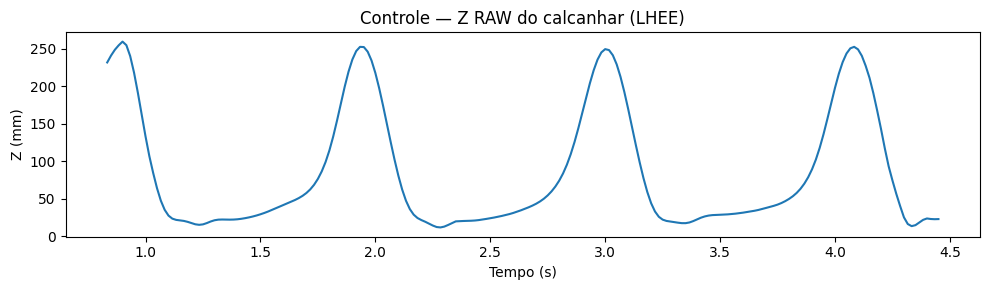

NaNs (%): 21.014492753623188


In [ ]:
example = "Controle"   # troque para: "PD_ON", "PD_OFF", "Ataxia"
path = files[example]

t, labels, xyz, res, _ = load_vicon_mat(path)

# escolher marcador com fallback
marker = "LHEE" if "LHEE" in labels else ("RHEE" if "RHEE" in labels else None)
print("Condição:", example)
print("Marcador:", marker)

mxyz = get_marker_xyz(labels, xyz, marker)
z_raw = mxyz[:, 2]  # Z bruto (mm)

plt.figure(figsize=(10,3))
plt.plot(t, z_raw)
plt.xlabel("Tempo (s)")
plt.ylabel("Z (mm)")
plt.title(f"{example} — Z RAW do calcanhar ({marker})")
plt.tight_layout()
plt.show()

print("NaNs (%):", 100*np.mean(~np.isfinite(z_raw)))


## 5A) Interpolação (preencher NaNs)

### O que fazer
Complete a função `fill_nans_1d` para preencher valores ausentes por **interpolação linear**.

### Matemática (ideia)
Se temos pontos válidos \((t_i, z_i)\), a interpolação linear preenche valores entre eles conectando por uma reta.

### Checklist
- Use `np.isfinite` para achar amostras válidas.
- Use `np.interp` para preencher.
- Se houver menos de 2 pontos válidos, retorne o vetor como está.


In [ ]:
def fill_nans_1d(x):
    """Preenche NaNs em 1D por interpolação linear."""
    x = np.asarray(x, dtype=float)
    idx = np.arange(len(x))
    good = np.isfinite(x)

    # TODO: se não houver dados suficientes, retorne x
    # TODO: crie uma cópia x2 e preencha os NaNs com np.interp
    # TODO: retorne x2

    return x  # <- substitua


### Checagem rápida (RAW vs Interpolado)
Depois de completar a função acima, rode esta célula.

In [ ]:
z_f = fill_nans_1d(z_raw)

plt.figure(figsize=(10,3))
plt.plot(t, z_raw, alpha=0.35, label="RAW (com NaNs)")
plt.plot(t, z_f,  alpha=0.9,  label="Interpolado")
plt.xlabel("Tempo (s)")
plt.ylabel("Z (mm)")
plt.title(f"{example} — RAW vs Interpolado")
plt.legend()
plt.tight_layout()
plt.show()


## 5B) Suavização e velocidade vertical

Vamos suavizar \(z(t)\) e calcular a velocidade vertical:

\[
 v_z(t) = \frac{dz}{dt}
\]

Usaremos:
- **Savitzky–Golay** para suavização - smooth window de 0.15 - Frequencia de 60hz
- `np.gradient` como aproximação numérica da derivada


In [ ]:
from scipy.signal import savgol_filter

fs = 1 / np.mean(np.diff(t))

    # implementar suavização
    # computar [ v_z(t) = \frac{dz}{dt} ]


print("fs (Hz):", round(fs, 2), "| janela (amostras):", win)

plt.figure(figsize=(10,3))
plt.plot(t, z_f, alpha=0.35, label="Interpolado")
plt.plot(t, z_s, label="Suavizado")
plt.xlabel("Tempo (s)")
plt.ylabel("Z (mm)")
plt.title("Sinal interpolado vs suavizado")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(t, vz, label="vz = dz/dt")
plt.xlabel("Tempo (s)")
plt.ylabel("vz (mm/s)")
plt.title("Velocidade vertical do calcanhar")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'win' is not defined

In [ ]:
from scipy.signal import find_peaks

min_step_time = 0.35
min_dist = int(min_step_time * fs)

prominence = 10  # <- EXPERIMENTE: 5, 10, 20, 50
peaks, props = find_peaks(vz, distance=min_dist, prominence=prominence)
event_times = t[peaks]

print("N eventos:", len(event_times))
print("event_times (s):", np.round(event_times[:10], 3), "..." if len(event_times)>10 else "")

plt.figure(figsize=(10,3))
plt.plot(t, vz, label="vz")
plt.plot(event_times, vz[peaks], "o", label="eventos (picos)")
plt.xlim(1.0, 4.8)
plt.xlabel("Tempo (s)")
plt.ylabel("vz (mm/s)")
plt.title(f"Eventos (picos em vz) — prominence={prominence}")
plt.legend()
plt.tight_layout()
plt.show()


## 5C) Detectar eventos (proxy) com picos em $v_z$

### Ideia
Detectar picos em $v_z$ com `find_peaks`.
find_peaks(vz, distance=min_dist, prominence=prominence)

### Parâmetros para explorar
- `prominence`: quão "marcado" o pico precisa ser
- `min_step_time`: impede detectar eventos muito próximos

> **Tarefa:** teste diferentes valores de `prominence` (5, 10, 20, 50) e observe.


## 6) Métricas temporais (cadência e variabilidade)

Se os eventos ocorrem em tempos $t_1, t_2, ..., t_n$:

**Intervalos:**
\[
\Delta t_i = t_{i+1} - t_i
\]

**Cadência (spm):**
\[
\text{cadência} = \frac{60}{\overline{\Delta t}}
\]

**Variabilidade (CV %):**
\[
CV = 100 \cdot \frac{s_{\Delta t}}{\overline{\Delta t}}
\]


## 7) Métricas espaciais (stride length e velocidade)

Vamos escolher um eixo de progressão (X ou Y) e calcular:

**Stride length (mesmo pé):**
\[
L_i = |p(t_{i+1}) - p(t_i)|
\]

**Velocidade média por stride:**
\[
v_i = \frac{L_i}{\Delta t_i}
\]

> Aqui, $p(t)$ é a posição no eixo escolhido (convertida de mm para m).


## 8) Generalizar: rodar para todos os participantes (tabela)

Agora que o pipeline funciona para **1** condição, rode para todas e compare.

> **Dica:** use os mesmos parâmetros (`smooth_window_s`, `prominence`, `min_step_time`).


In [ ]:
def run_pipeline_for_one(path, prefer_marker="LHEE", prominence=10, smooth_window_s=0.15, min_step_time=0.35):
    # carregar
    t, labels, xyz, res, _ = load_vicon_mat(path)
    marker = prefer_marker if prefer_marker in labels else ("RHEE" if "RHEE" in labels else None)
    if marker is None:
        return {"marker":"NA"}

    mxyz = get_marker_xyz(labels, xyz, marker)
    z_raw = mxyz[:, 2]

    # interpolar (usa a sua função)
    z_f = fill_nans_1d(z_raw)

    # suavizar + derivar
    fs = 1 / np.mean(np.diff(t))
    win = int(smooth_window_s * fs)
    win = max(win, 5)
    if win % 2 == 0:
        win += 1

    z_s = savgol_filter(z_f, window_length=win, polyorder=2)
    vz = np.gradient(z_s, t)

    # eventos
    min_dist = int(min_step_time * fs)
    peaks, _ = find_peaks(vz, distance=min_dist, prominence=prominence)
    event_times = t[peaks]

    # métricas temporais
    intervals = np.diff(event_times)
    mean_dt = np.mean(intervals) if len(intervals) > 0 else np.nan
    cadence = 60.0/mean_dt if np.isfinite(mean_dt) else np.nan
    cv = 100*np.std(intervals, ddof=1)/mean_dt if len(intervals) >= 3 else np.nan

    # métricas espaciais
    xy = mxyz[:, :2]
    amp = np.nanmax(xy, axis=0) - np.nanmin(xy, axis=0)
    axis_idx = int(np.nanargmax(amp))
    axis_name = "X" if axis_idx == 0 else "Y"

    pos = mxyz[:, axis_idx] / 1000.0
    pos_e = pos[peaks]
    t_e = t[peaks]

    dt = np.diff(t_e)
    stride_len = np.abs(np.diff(pos_e))
    speed = stride_len / dt if len(dt) > 0 else np.array([])

    return {
        "marker": marker,
        "fs_hz": float(fs),
        "n_events": int(len(event_times)),
        "cadence_spm": float(cadence) if np.isfinite(cadence) else np.nan,
        "cv_interval_pct": float(cv) if np.isfinite(cv) else np.nan,
        "stride_length_m": float(np.mean(stride_len)) if len(stride_len)>0 else np.nan,
        "stride_time_s": float(np.mean(dt)) if len(dt)>0 else np.nan,
        "speed_mps": float(np.mean(speed)) if len(speed)>0 else np.nan,
        "nan_pct_z": float(100*np.mean(~np.isfinite(z_raw)))
    }

rows = []
for cond, path in files.items():
    out = run_pipeline_for_one(path, prominence=prominence, smooth_window_s=smooth_window_s, min_step_time=min_step_time)
    out["cond"] = cond
    rows.append(out)

df = pd.DataFrame(rows).set_index("cond")
df


## 9) Discussão guiada

1. Qual condição teve **menor velocidade**? Isso bate com a expectativa clínica?
2. A variabilidade (CV) mudou entre condições?
3. Quem teve maior **% de NaNs**? Como isso pode afetar os resultados?
4. O que mudaria no detector para reduzir falsos positivos? (ex.: usar Z mínimo, usar toe marker, usar filtros adicionais)


---

# (Opcional) Gabarito do professor

Se você quiser manter um gabarito no fim do notebook, cole aqui a versão robusta com filtros (pé baixo + refratário).
Durante a atividade, **não rode** esta parte.